<h1><div align = "center">YouTube Data Analysis</div></h1>

<h3>Importing libraries</h3>

In [1]:
import json
import re
from datetime import datetime, timedelta
from apiclient.discovery import build
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import norm

<h2>Provide an API_KEY to work with YouTube Data API.</h2>

In [2]:
API_KEY = "" # Enter your API KEY here

<h3>Constructing a resource for iteracting with an API.</h3>

In [3]:
youtube = build('youtube', 'v3', developerKey = API_KEY)

<h2>Provide the Channel Title for analysis.</h2>
<h2>Let's analyse the India's Most Popular YouTube Channel "CarryMinati".</h2>

In [4]:
channel_title = "CarryMinati" # Enter the channel Title here

<h3>Get Channel ID</h3>

In [5]:
def get_channel_id(channel_title):
    channel_id = None
    
    request = youtube.search().list(q = channel_title, type = 'channel', part = 'id, snippet').execute()
    try:
        channel_id = request['items'][0]['id']['channelId']
        print(channel_id)
    except:
        channel_id = None
        print("Channel Not Available")
    return channel_id

In [6]:
channel_id = get_channel_id(channel_title)

UCj22tfcQrWG7EMEKS0qLeEg


<h3>Get Channel Statistics</h3>

In [7]:
def get_channel_statistics(channel_id):
    channel_statistics = None

    request = youtube.channels().list(id = channel_id, part = 'statistics').execute()
    channel_statistics = request['items'][0]['statistics']
    
    print(json.dumps(channel_statistics, indent = 4))
    
    return channel_statistics

In [8]:
channel_statistics = get_channel_statistics(channel_id)

{
    "viewCount": "2048156711",
    "subscriberCount": "27800000",
    "hiddenSubscriberCount": false,
    "videoCount": "172"
}


<h3>Get Video ID's</h3>

In [9]:
def get_video_ids(channel_id):
    playlistId = None
    
    request = youtube.channels().list(id = channel_id, part = 'contentDetails').execute()
    playlist_id = request['items'][0]['contentDetails']['relatedPlaylists']['uploads']
    
    videos = []
    next_page_token = None
    
    while True:
        request = youtube.playlistItems().list(playlistId = playlist_id, part = 'snippet', maxResults = 50, pageToken = next_page_token).execute()
        videos += request['items']
        next_page_token = request.get('nextPageToken')
        
        if next_page_token is None:
            break
    
    video_ids = []
    for video in videos:
        video_ids.append(video['snippet']['resourceId']['videoId'])

    # print(json.dumps(video_ids, indent = 2))
    return video_ids

In [10]:
video_ids = get_video_ids(channel_id)

<h3>Get Videos Data</h3>

In [11]:
def get_single_video_data(video_id):
    request = youtube.videos().list(id = video_id, part = 'snippet, statistics, contentDetails').execute()
    return request

In [12]:
def get_channel_video_data(video_ids):    
    video_data = {}

    for video_id in tqdm(video_ids):
        video_data[video_id] = dict(get_single_video_data(video_id))
    
    # print(json.dumps(video_data, indent = 4))
    return video_data


In [13]:
video_data = get_channel_video_data(video_ids)

100%|██████████| 172/172 [00:35<00:00,  4.91it/s]


<h3>Dump the Channel Data</h3>

In [14]:
def dump(channel_title, channel_id, channel_statistics, video_data):
    if channel_statistics is None or video_data is None:
        print("Data is none")
        return
    
    fused_data = {channel_id: {"channel_title": channel_title, "channel_statistics": channel_statistics, "video_data": video_data}}
    
    channel_title = channel_title.replace(" ", "_")
    file_name = channel_title + '.json'
    with open("data/" + file_name, 'w') as f:
        json.dump(fused_data, f, indent = 4)
    print("File Dumped")

In [15]:
dump(channel_title, channel_id, channel_statistics, video_data)

File Dumped


<h2>Read JSON file</h2>

In [16]:
file = "data/CarryMinati.json"
data = None
with open(file, 'r') as f:
    data = json.load(f)

channel_id, stats = data.popitem()

channel_stats = stats['channel_statistics']
video_stats = stats['video_data']

<h2>Channel ID and Channel Title</h2>

In [17]:
print("Channel ID :", channel_id)
print("Channel Title :", stats['channel_title'])

Channel ID : UCj22tfcQrWG7EMEKS0qLeEg
Channel Title : CarryMinati


<h2>Channel Statistics</h2>

In [18]:
print("Views :", channel_stats['viewCount'])
print("Subscriber Count :", channel_stats['subscriberCount'])
print("Videos Count:", channel_stats['videoCount'])

Views : 2048156711
Subscriber Count : 27800000
Videos Count: 172


<h2>Video Statistics</h2>

<h3>Parsing video's duration and Publish time</h3>

In [19]:
def parse_duration(video):
    duration = video_stats[video]['items'][0]['contentDetails']['duration']
    hours = hours_pattern.search(duration)
    minutes = minutes_pattern.search(duration)
    seconds = seconds_pattern.search(duration)

    hours = int(hours.group(1)) if hours else 0
    minutes = int(minutes.group(1)) if minutes else 0
    seconds = int(seconds.group(1)) if seconds else 0

    video_seconds = timedelta(
        hours = hours,
        minutes = minutes,
        seconds = seconds
    ).total_seconds()

    duration_minutes = round(video_seconds / 60, 2)

    return duration_minutes

In [20]:
def parse_publish_time(video):
    publish_timestamp = (datetime.strptime(video_stats[video]['items'][0]['snippet']['publishedAt'], "%Y-%m-%dT%H:%M:%SZ") + timedelta(hours = 5, minutes = 30))
    publish_time = round(publish_timestamp.hour + publish_timestamp.minute / 60, 2)
    return publish_time

In [21]:
stats = []

hours_pattern = re.compile(r'(\d+)H')
minutes_pattern = re.compile(r'(\d+)M')
seconds_pattern = re.compile(r'(\d+)S')

for video in video_stats:
    video_id = video
    title = video_stats[video]['items'][0]['snippet']['title']
    views = video_stats[video]['items'][0]['statistics'].get('viewCount')
    if views:
        views = int(views)
    else:
        views = np.NaN
    likes = video_stats[video]['items'][0]['statistics'].get('likeCount')
    if likes:
        likes = int(likes)
    else:
        likes = np.NaN    
    dislikes = video_stats[video]['items'][0]['statistics'].get('dislikeCount')
    if dislikes:
        dislikes = int(dislikes)
    else:
        dislikes = np.NaN
    comments = video_stats[video]['items'][0]['statistics'].get('commentCount')
    if comments:
        comments = int(comments)
    else:
        comments = np.NaN
    duration_minutes = parse_duration(video)
    publish_time = parse_publish_time(video)
    
    stats.append([video_id, title, views, likes, dislikes, comments, duration_minutes, publish_time])

In [22]:
df = pd.DataFrame(stats, columns = ['video_id', 'title', 'views', 'likes', 'dislikes', 'comments', 'duration_minutes', 'publish_time_hours'])
df.head()

,video_id,title,views,likes,dislikes,comments,duration_minutes,publish_time_hours
0,W2uUlW8PLOY,MASSAGE PARADISE,25108375,4153102,75736,204768.0,8.37,17.20
1,abhuAYtmk58,IDLES OF INDIA: GONE RIGHT,31083613,4786666,120052,284771.0,8.92,15.88
2,q2QvA3wwAe0,THE ART OF BAD WORDS,37552488,5755481,140576,396053.0,8.07,21.23
3,zzwRbKI2pn4,YALGAAR - CARRYMINATI X Wily Frenzy,195391126,13560021,360951,1618270.0,3.25,22.53
4,WUdo9lzpaas,YALGAAR....COMING SOON,36181140,4856610,67039,341982.0,1.73,20.00


<h2>Data Visualization</h2>

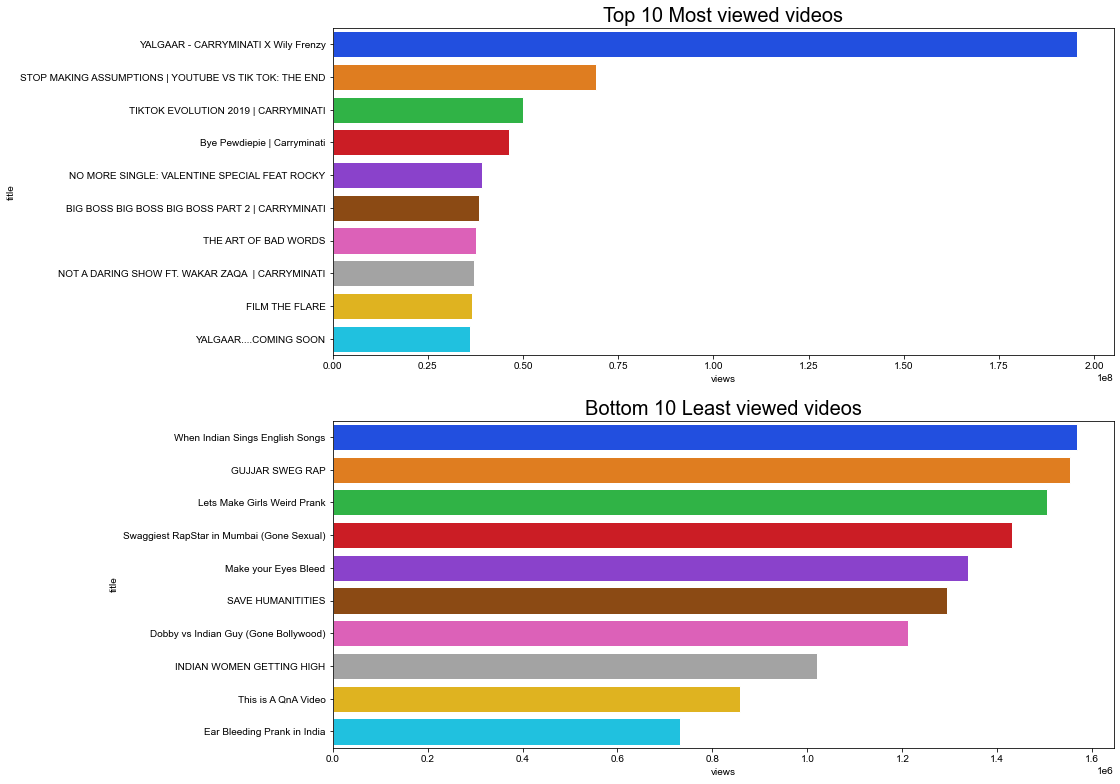

In [23]:
temp = df.copy()
fig, (ax1, ax2) = plt.subplots(2, figsize = (14, 10))
sns.set_theme(font_scale = 1.2)
temp = temp.sort_values(by = 'views', ascending = False)
temp.dropna(inplace = True)
top_10 = temp.head(10)
bottom_10 = temp.tail(10)
fig.subplots_adjust(top = 2, bottom = 1)
ax1.set_title("Top 10 Most viewed videos", fontsize = 20)
ax2.set_title("Bottom 10 Least viewed videos", fontsize = 20)
sns.barplot(data = top_10, y = 'title', x = 'views', palette = 'bright', ax = ax1)
sns.barplot(data = bottom_10, y = 'title', x = 'views', palette = 'bright', ax = ax2)
plt.show()

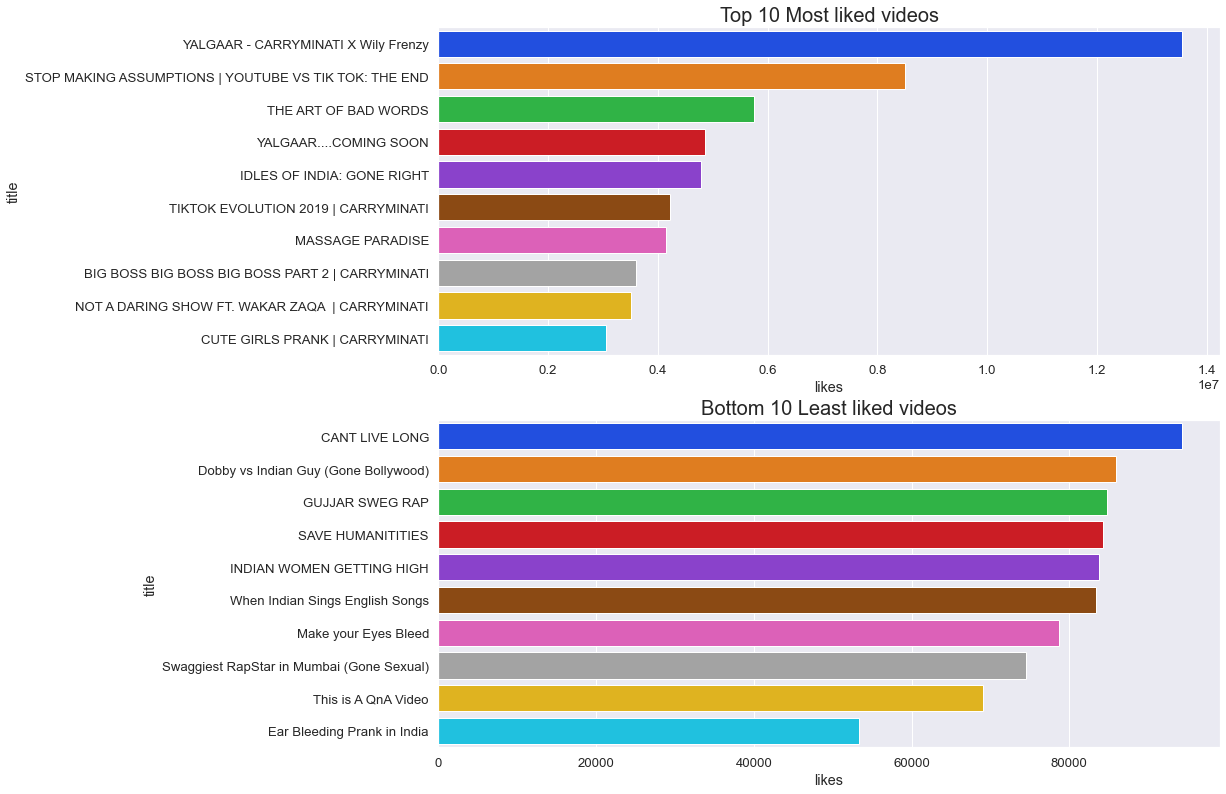

In [24]:
temp = df.copy()
fig, (ax1, ax2) = plt.subplots(2, figsize = (14, 10))
sns.set_theme(font_scale = 1.2)
temp = temp.sort_values(by = 'likes', ascending = False)
temp.dropna(inplace = True)
top_10 = temp.head(10)
bottom_10 = temp.tail(10)
fig.subplots_adjust(top = 2, bottom = 1)
ax1.set_title("Top 10 Most liked videos", fontsize = 20)
ax2.set_title("Bottom 10 Least liked videos", fontsize = 20)
sns.barplot(data = top_10, y = 'title', x = 'likes', palette = 'bright', ax = ax1)
sns.barplot(data = bottom_10, y = 'title', x = 'likes', palette = 'bright', ax = ax2)
plt.show()

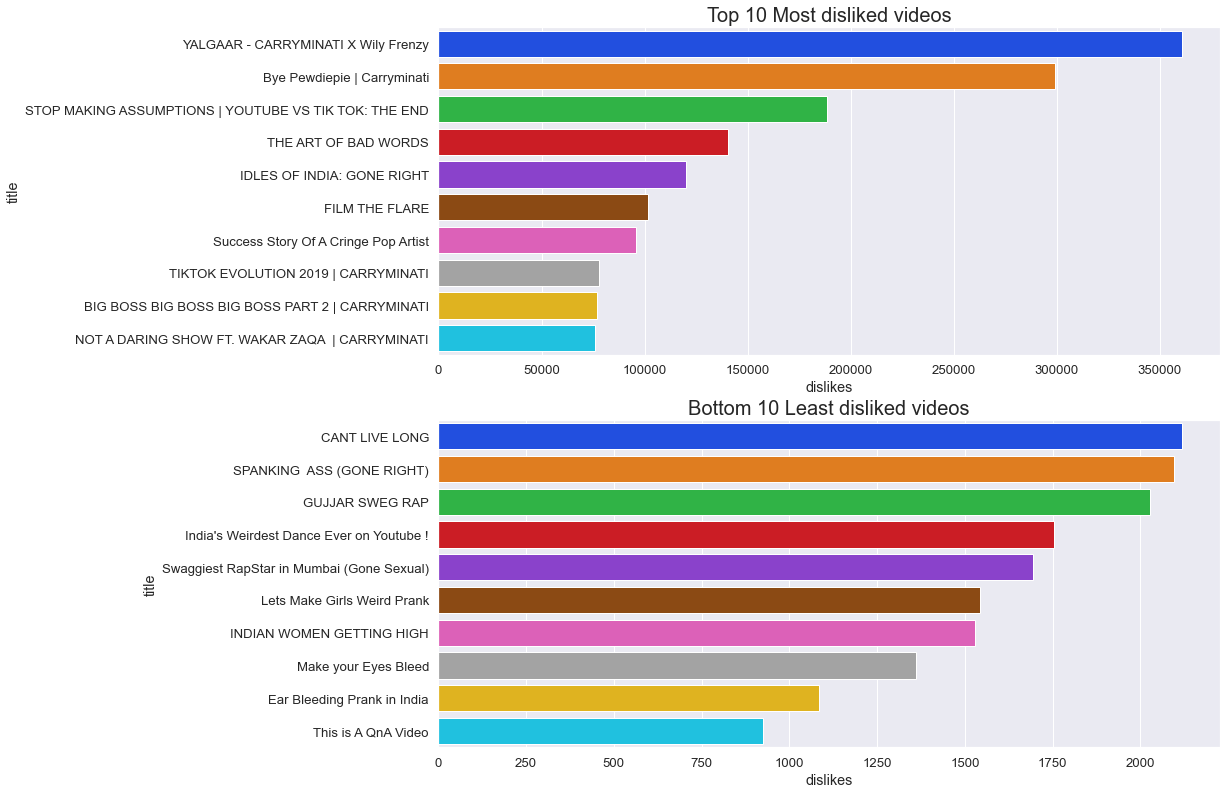

In [25]:
temp = df.copy()
fig, (ax1, ax2) = plt.subplots(2, figsize = (14, 10))
sns.set_theme(font_scale = 1.2)
temp = temp.sort_values(by = 'dislikes', ascending = False)
temp.dropna(inplace = True)
top_10 = temp.head(10)
bottom_10 = temp.tail(10)
fig.subplots_adjust(top = 2, bottom = 1)
ax1.set_title("Top 10 Most disliked videos", fontsize = 20)
ax2.set_title("Bottom 10 Least disliked videos", fontsize = 20)
sns.barplot(data = top_10, y = 'title', x = 'dislikes', palette = 'bright', ax = ax1)
sns.barplot(data = bottom_10, y = 'title', x = 'dislikes', palette = 'bright', ax = ax2)
plt.show()

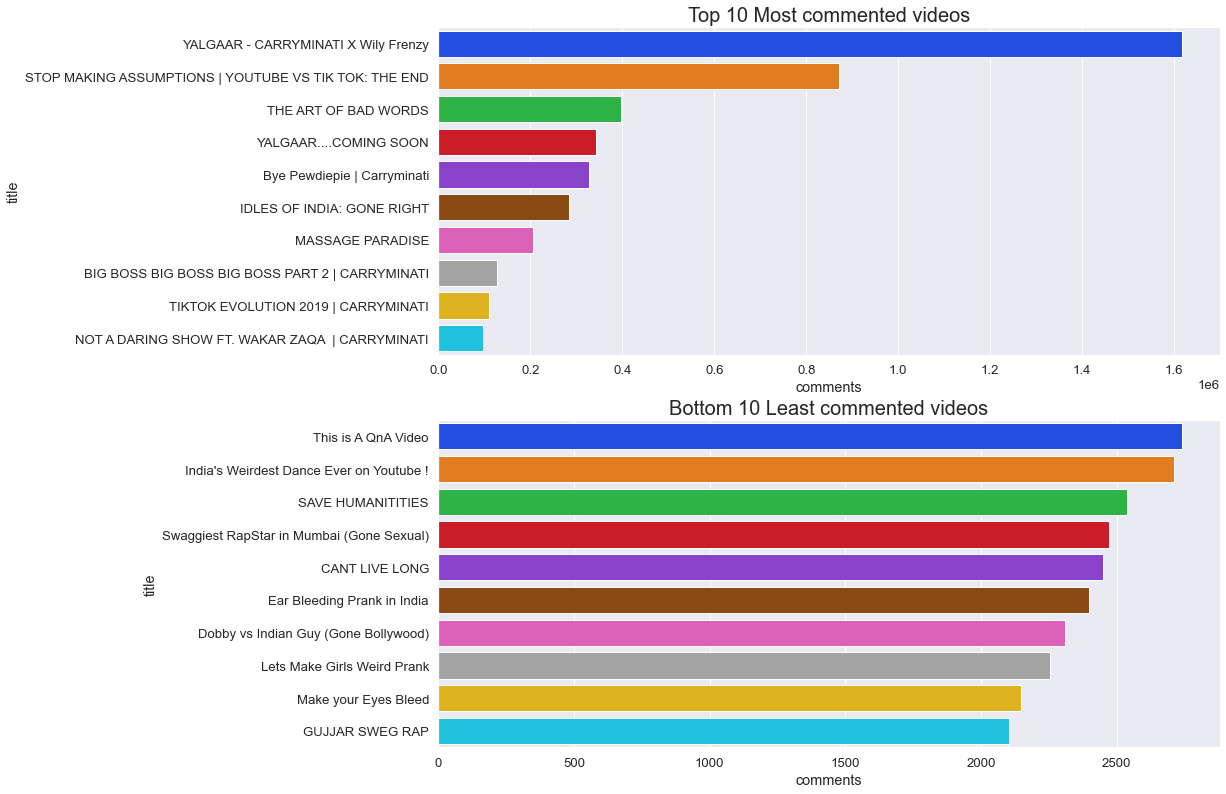

In [26]:
temp = df.copy()
fig, (ax1, ax2) = plt.subplots(2, figsize = (14, 10))
sns.set_theme(font_scale = 1.2)
temp = temp.sort_values(by = 'comments', ascending = False)
temp.dropna(inplace = True)
top_10 = temp.head(10)
bottom_10 = temp.tail(10)
fig.subplots_adjust(top = 2, bottom = 1)
ax1.set_title("Top 10 Most commented videos", fontsize = 20)
ax2.set_title("Bottom 10 Least commented videos", fontsize = 20)
sns.barplot(data = top_10, y = 'title', x = 'comments', palette = 'bright', ax = ax1)
sns.barplot(data = bottom_10, y = 'title', x = 'comments', palette = 'bright', ax = ax2)
plt.show()

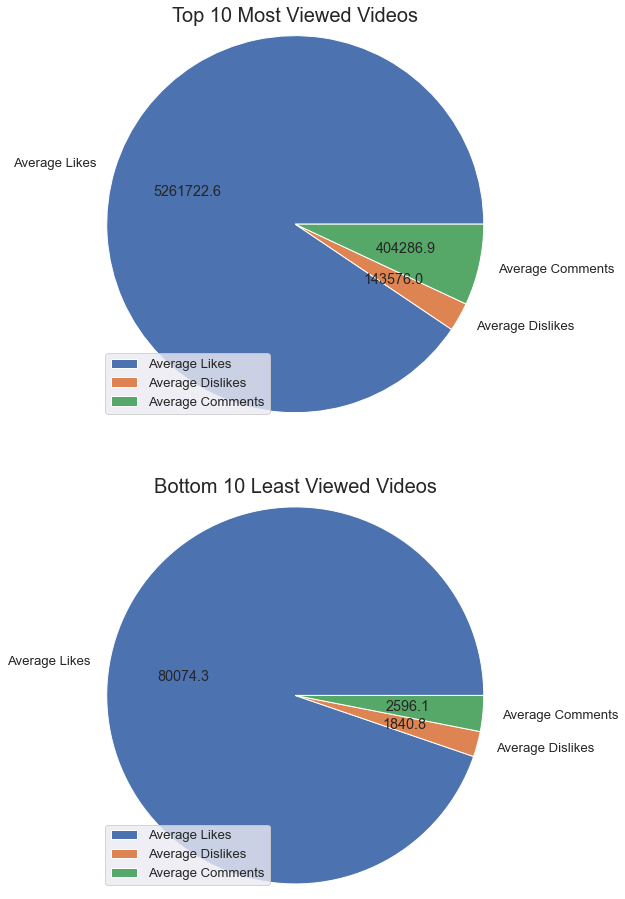

In [27]:
temp = df.copy()
temp.dropna(inplace = True)
temp = temp.sort_values(by = 'views', ascending = False)
top_10 = temp.head(10)
labels = ['Average Likes', 'Average Dislikes', 'Average Comments']
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,12))
fig.subplots_adjust(top = 2, bottom = 1)
likes_avg = np.mean(top_10['likes'])
dislikes_avg = np.mean(top_10['dislikes'])
comments_avg = np.mean(top_10['comments'])

avg_data = [likes_avg, dislikes_avg, comments_avg]

p, tx, autotexts = ax1.pie(avg_data, labels = labels, radius = 1.2, autopct = '')
for i, a in enumerate(autotexts):
    a.set_text("{}".format(avg_data[i]))
ax1.legend(loc = 'lower left')
ax1.set_title("Top 10 Most Viewed Videos", fontsize = 20)

bottom_10 = temp.tail(10)

likes_avg = np.mean(bottom_10['likes'])
dislikes_avg = np.mean(bottom_10['dislikes'])
comments_avg = np.mean(bottom_10['comments'])

avg_data = [likes_avg, dislikes_avg, comments_avg]

p, tx, autotexts = ax2.pie(avg_data, labels = labels, radius = 1.2, autopct = '')
for i, a in enumerate(autotexts):
    a.set_text("{}".format(avg_data[i]))
ax2.legend(loc = 'lower left')
ax2.set_title("Bottom 10 Least Viewed Videos", fontsize = 20)

plt.show()

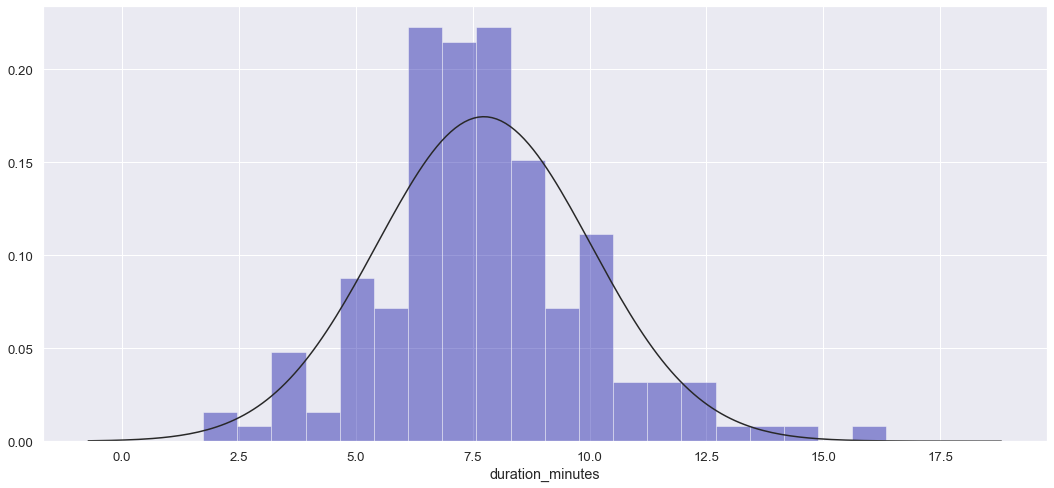

In [28]:
temp = df['duration_minutes']
plt.figure(figsize= (18, 8))
sns.distplot(temp, fit = norm, kde = False, color = ['#0000A0'], bins = 20)
plt.xticks()
plt.show()

<h3>Majority of the videos have duration ranging from 5 min to 13 min.</h3>

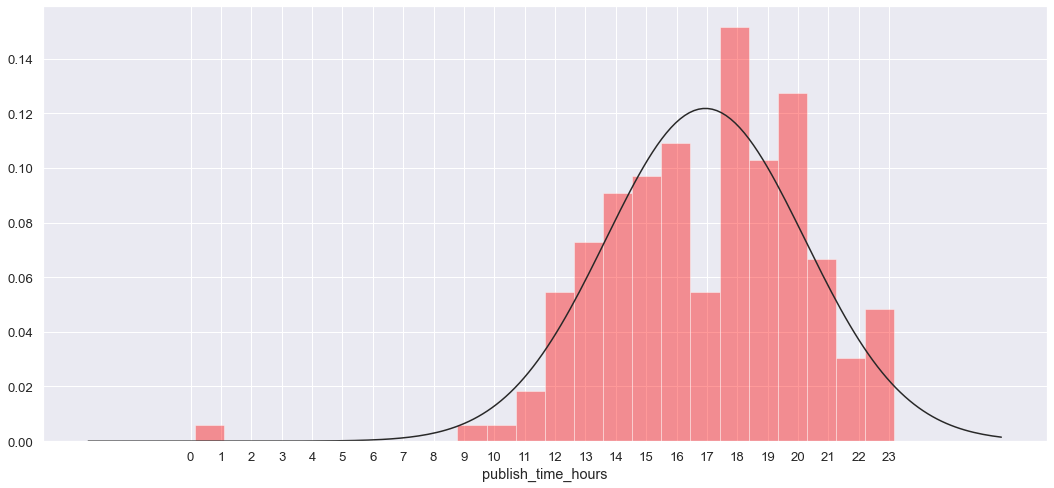

In [29]:
temp = df['publish_time_hours']
plt.figure(figsize= (18, 8))
sns.distplot(temp, fit = norm, kde = False, color = ['#FF0000'], bins = 24)
plt.xticks(range(24))
plt.show()

<h3>According to the Time zone of India videos have publish time in between 9:00 AM to 1:00 AM.</h3>